# Brain Tumor Classification using CNN

This notebook implements a Convolutional Neural Network (CNN) to classify brain MRI scans into two categories:
1. Brain Tumor Present (Yes)
2. Brain Tumor Absent (No)

The model will be trained on a dataset of MRI scans and will learn to identify the presence of tumors with high accuracy.

## 1. Import Required Libraries

We'll import the necessary libraries for building our CNN model:
- Keras/TensorFlow for building and training the CNN
- scikit-learn for data splitting and preprocessing
- numpy for numerical operations
- matplotlib for visualization

In [37]:
# Import required libraries
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## 2. Data Import and Preprocessing

In this section, we will:
1. Load MRI images from the dataset
2. Resize all images to 128x128x3 dimension
3. Convert labels to one-hot encoded format
4. Combine data from both classes (tumor present/absent)

The dataset contains two folders:
- 'yes': Contains MRI scans with brain tumors
- 'no': Contains MRI scans without brain tumors

In [ ]:
# Initialize OneHotEncoder and fit it with possible values
encoder = OneHotEncoder(sparse_output=False)
encoder.fit([[0], [1]])  # Fit with possible values (0 for tumor, 1 for no tumor)

# Initialize lists
data = []
paths = []
result = []

# Load images with tumor
for r, d, f in os.walk(r"brain_tumor_dataset/yes"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))
            
for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]))  # 0 for tumor - returns numpy array directly

# Load images without tumor
paths = []
for r, d, f in os.walk(r"brain_tumor_dataset/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))
            
for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]))  # 1 for no tumor - returns numpy array directly

# Convert to numpy arrays
data = np.array(data)
result = np.array(result)
result = result.reshape(-1, 2)

print("Dataset shape:", data.shape)
print(f"Total number of images we have: {len(data)}")

Dataset shape: (139, 128, 128, 3)
Total number of images we have: 139


## 3. Train-Test Split

We'll split our dataset into:
- Training set (80% of data)
- Testing set (20% of data)

This split ensures we can evaluate our model on unseen data.

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, 
    result,
    test_size=0.2,    # 20% for testing
    random_state=42    # For reproducibility
)

# Print the shapes of training and testing sets
print("Training set shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing set shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training set shape: (111, 128, 128, 3)
Training labels shape: (111, 2)
Testing set shape: (28, 128, 128, 3)
Testing labels shape: (28, 2)


## 4. CNN Model Architecture

We'll build a CNN with the following components:
1. Convolutional layers with ReLU activation
2. MaxPooling layers for downsampling
3. Batch Normalization for stabilizing training
4. Dropout layers to prevent overfitting
5. Dense layers for final classification

The architecture follows this pattern:
- Conv2D -> ReLU -> BatchNorm -> MaxPool -> Dropout
- Conv2D -> ReLU -> BatchNorm -> MaxPool -> Dropout
- Flatten
- Dense -> Softmax

In [40]:
# Initialize the CNN model
model = Sequential()

# First set of Conv layers
model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding='Same'))
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', padding='Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second set of Conv layers
model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='Same'))
model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Flatten and Dense layers
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer='Adamax')
print(model.summary())

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,585,602 (128.12 MB)

 Trainable params: 33,585,410 (128.12 MB)

 Non-trainable params: 192 (768.00 B)

None


## 5. Model Training

We'll train the model for 30 epochs with the following parameters:
- Batch size: 32
- Validation split: 20% of training data
- Monitor both training and validation loss/accuracy

In [42]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=40,
    epochs=30,
    validation_data=(X_test,y_test),
    verbose=1
)



Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.2580 - val_loss: 0.8647
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0017 - val_loss: 1.0240
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 4.8321e-06 - val_loss: 1.1855
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 5.8852e-07 - val_loss: 1.3155
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 4.7687e-04 - val_loss: 1.3868
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 1.5278e-04 - val_loss: 1.4228
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 2.8895e-04 - val_loss: 1.4316
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 8.9461e-06 - val_loss: 1.4165
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 4.5687e-05 - val_loss: 1.3917
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 5.3014e-05 - val_loss: 1.3586
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 9.0704e-06 - val_loss: 1.3242
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 8.3837e-05 - v

## 6. Model Evaluation and Visualization

Let's visualize the training process by plotting:
1. Training vs Validation Loss
2. Training vs Validation Accuracy

This will help us understand if the model is overfitting or underfitting.

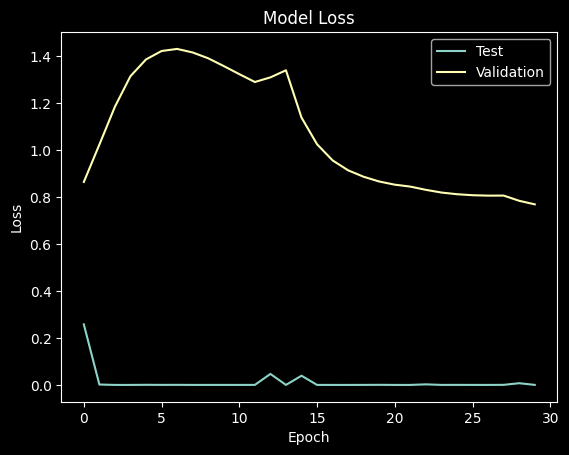

In [44]:


# Plot training & validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Test','Validation'],loc='upper right')
plt.show()


## 7. Testing Model Predictions

Let's test our model on some sample images from the test set and visualize:
1. The input MRI scan
2. The true label
3. The model's prediction with confidence score

In [50]:
# Function to return prediction name
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'


In [ ]:
from matplotlib.pyplot import imshow
# Load and convert image
img = Image.open(r"brain_tumor_dataset/no/N3.jpg").convert('RGB')  # Ensure RGB format
x = np.array(img.resize((128,128)))
print("Image shape:", x.shape)  # Debug print
x = x.reshape(1,128,128,3)

res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

In [ ]:
from matplotlib.pyplot import imshow
# Load and convert image
img = Image.open(r"brain_tumor_dataset/no/N3.jpg").convert('RGB')  # Ensure RGB format
x = np.array(img.resize((128,128)))
print("Image shape:", x.shape)  # Debug print
x = x.reshape(1,128,128,3)

res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))